In [50]:
# Imports
import bson
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

## Les fichiers bson

In [2]:
# Open and read the BSON files
with open("./trictrac/details.bson", "rb") as f:
    details = bson.decode_all(f.read())
    
    
with open("./trictrac/infos_scrapping.bson", "rb") as f:
    infos = bson.decode_all(f.read())
    
with open("./trictrac/jeux.bson", "rb") as f:
    jeux = bson.decode_all(f.read())


with open("./trictrac/avis.bson", "rb") as f:
    avis = bson.decode_all(f.read())
    

## Visualisation d'un elements de chaque table

In [55]:
i=0
print(f"L'element {i} de la table des avis:\n",avis[i])
print(f"\nL'element {i} de la table des jeux:\n",jeux[i])
print(f"\nL'element {i} de la infos_scrapping des avis:\n",infos[i])
print(f"\nL'element {i} de la details des avis:\n",details[i])

L'element 4 de la table des avis:
 {'_id': ObjectId('63c6726ea81f3e3016af9a5a'), 'author': 'prunelles', 'date_published': '2021-05-24 12:43:18', 'title_review': 'Envolez-moi', 'note': 9, 'review_href': 'https://www.trictrac.net/avis/envolez-moi', 'title': 'Mariposas', 'url': 'https://www.trictrac.net/jeu-de-societe/mariposas/avis?limit=10000', 'treated': True, 'comment': 'Très joli bijou que ce jeu-là ! Le matériel, les illustrations, l\'histoire et le propos du jeu, tout donne envie de contribuer à sauver ces papillons.\nBelle courbe d\'apprentissage, impossible de tout faire même si on essaie parfois.\nLe mini bemol serait les papillons qu\'on n\'arrive pas toujours à visualiser parce que certaines couleurs sont proches mais en même ça nous permet de les camoufler aussi aux yeux de nos adversaires.\nPensez à aller regarder les différentes variantes concernant les cartes "cycle de vie". \nUne belle réussite !'}

L'element 4 de la table des jeux:
 {'_id': ObjectId('63c178091eefabb8eb02

In [4]:
len_details=len(details)
len_jeux=len(jeux)
len_infos=len(infos)
len_avis=len(avis)
print(f"Longeur de chaque table de données avis: {len_avis}, jeux: {len_jeux}, infos: {len_infos}, details : {len_details}")

no_cat = 0
for d in details:
    if d["categories"]=="":
        no_cat+=1
        
print(f"Nombre de jeux sans categorie: {no_cat}, poucentage de jeux non catégorisé: {((no_cat/len(details))*100):.2f}%")


Longeur de chaque table de données avis: 246524, jeux: 20235, infos: 532, details : 20234
Nombre de jeux sans categorie: 3019, poucentage de jeux non catégorisé: 14.92%


## Crée des panda dataframes

In [5]:
pdDetails = pd.DataFrame(details)
pdJeux = pd.DataFrame(jeux)
pdInfos = pd.DataFrame(infos)
pdAvis = pd.DataFrame(avis)

print("Details:\n", pdDetails.describe())
print("\nAvis:\n", pdAvis.describe())
print("\nInfos:\n", pdInfos.describe())
print("\nJeux:\n", pdJeux.describe())

Details:
                Note  Note rectifiée   Note Finkel  Nombre d'avis  \
count  20234.000000    20234.000000  20234.000000   20234.000000   
mean       4.852528        4.591857      4.897049      15.583671   
std        3.666644        3.684093      4.157989      57.265863   
min        0.000000        0.000000     -0.050000       0.000000   
25%        0.000000        0.000000      0.000000       0.000000   
50%        6.270000        6.000000      6.010000       2.000000   
75%        8.000000        7.940000      8.090000       9.000000   
max       10.000000       10.000000     41.720000    1452.000000   

       Nombre d'avis rectifiés  
count             20234.000000  
mean                 11.663438  
std                  41.129909  
min                   0.000000  
25%                   0.000000  
50%                   1.000000  
75%                   7.000000  
max                 907.000000  

Avis:
                note
count  246524.00000
mean        7.59307
std         

In [7]:
pdDetails.tail()

,_id,categories,casting,gameplay,description,full_title,titre,url,Note,Note rectifiée,Note Finkel,Nombre d'avis,Nombre d'avis rectifiés
20229,63c7effdca188a9a85b03014,Jeux de guerre,Par Richard BergIllustré par Craig GrandoÉdité...,jusqu'à 2|14 à 99 |180,\n Golden Horde est une s...,Golden Horde (2006),Golden Horde,https://www.trictrac.net/jeu-de-societe/golden...,0.00,0.00,0.00,0.0,0.0
20230,63c7effeca188a9a85b0302c,Jeux de guerre,Par John PradosIllustré par Craig GrandoÉdité ...,jusqu'à 2|14 à 99 |180,\n Toppling the Reich est...,Toppling The Reich (2006),Toppling The Reich,https://www.trictrac.net/jeu-de-societe/toppli...,0.00,0.00,0.00,0.0,0.0
20231,63c7effeca188a9a85b03046,Jeux de guerre,Par Mark StilleIllustré par Craig GrandoÉdité ...,jusqu'à 2|14 à 99 |240,\n Imperial Sunset est le...,Imperial Sunset (2006),Imperial Sunset,https://www.trictrac.net/jeu-de-societe/imperi...,0.00,0.00,0.00,0.0,0.0
20232,63c7efffca188a9a85b0306b,Jeux de cartes,Par Reiner KniziaIllustré par Michael SchoberÉ...,2 à 6|4 ans et +|15,\n Que s'est-il passé dan...,La Grande Pagaille (2006),La Grande Pagaille,https://www.trictrac.net/jeu-de-societe/la-gra...,8.00,8.00,8.09,3.0,3.0
20233,63c7f052ca188a9a85b03354,"Gestion|Hasard (Dé, Cartes, ...)|Pirate",Par Gilles BecqIllustré par Kevin WandrolÉdité...,2 à 4|10 ans et +|30,\n Soyez le premier à réu...,Dice Seadog (2013),Dice Seadog,https://www.trictrac.net/jeu-de-societe/dice-s...,5.77,5.55,5.56,3.0,2.0


In [8]:
pdJeux.tail()

,_id,title,href,treated,avis
20230,63c68a2f22080b33e5b59ce6,Quelques Arpents de Neige,https://www.trictrac.net/jeu-de-societe/quelqu...,True,False
20231,63c68a2f22080b33e5b59ce7,Toppling The Reich,https://www.trictrac.net/jeu-de-societe/toppli...,True,False
20232,63c68a2f22080b33e5b59ce8,La Vallée de la Mort,https://www.trictrac.net/jeu-de-societe/la-val...,True,False
20233,63c68a2f22080b33e5b59ce9,La Grande Pagaille,https://www.trictrac.net/jeu-de-societe/la-gra...,True,False
20234,63c68a2f22080b33e5b59cea,Imperial Sunset,https://www.trictrac.net/jeu-de-societe/imperi...,True,False


In [9]:
pdInfos.head()

,_id,url,num_page,count
0,63c17a0030ad62ea332eaea0,https://www.trictrac.net/jeu-de-societe/?order...,1,32
1,63c17a0130ad62ea332eaef0,https://www.trictrac.net/jeu-de-societe/?order...,0,32
2,63c17a0130ad62ea332eaf01,https://www.trictrac.net/jeu-de-societe/?order...,7,31
3,63c17a0130ad62ea332eaf02,https://www.trictrac.net/jeu-de-societe/?order...,6,32
4,63c17a0130ad62ea332eaf23,https://www.trictrac.net/jeu-de-societe/?order...,4,32


In [58]:
pdAvis.head(20)

,_id,author,date_published,title_review,note,review_href,title,url,treated,comment,year,review_length,month_year
0,63c6726ea81f3e3016af9a56,Monsieur Guillaume,2021-01-27 11:06:44,Voyages sur les ailes des papillons,8.0,https://www.trictrac.net/avis/vraiment-bon-12514,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021,619.0,2021-01
1,63c6726ea81f3e3016af9a57,morlockbob,2020-10-18 10:04:21,le festival de Michoacan,7.0,https://www.trictrac.net/avis/le-festival-de-m...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Comment continuer après un mega hit ? Simpleme...,2020,883.0,2020-10
2,63c6726ea81f3e3016af9a58,SwatSh,2021-02-01 08:35:08,Vivez la migration des monarques,7.0,https://www.trictrac.net/avis/vivez-la-migrati...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ...",2021,540.0,2021-02
4,63c6726ea81f3e3016af9a5a,prunelles,2021-05-24 12:43:18,Envolez-moi,9.0,https://www.trictrac.net/avis/envolez-moi,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Très joli bijou que ce jeu-là ! Le matériel, l...",2021,540.0,2021-05
5,63c6726ea81f3e3016af9a5b,BSI40,2022-09-23 17:16:27,Manque un peu de souffle,7.0,https://www.trictrac.net/avis/manque-un-peu-de...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Mariposas est plutôt beau avec un grand platea...,2022,1744.0,2022-09
6,63c6726ea81f3e3016af9a5c,kakawette,2020-09-10 23:16:35,"Papillon de lumière, sous les projecteurs",7.0,https://www.trictrac.net/avis/bon-13703,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Simple d'accès, mais tout de même un peu tacti...",2020,402.0,2020-09
12,63c6726ea81f3e3016af9a62,axelian73,2020-11-15 11:29:39,"Poétique et coloré, mais 1 point de règle à ra...",8.0,https://www.trictrac.net/avis/poetique-et-colo...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Un jeu magnifique mais on trouvait qu'il manqu...,2020,652.0,2020-11
13,63c6726ea81f3e3016af9a63,MisTeR ToON,2021-11-02 21:02:50,Les papillons migrent pour une nouvelle demeur...,6.0,https://www.trictrac.net/avis/les-papillons-mi...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Très déçu de Mariposas.\nOn a tendance à le co...,2021,913.0,2021-11
15,63c6726ea81f3e3016af9a65,Lilly,2020-11-03 17:30:05,Beau et Doux et Rapide,8.0,https://www.trictrac.net/avis/bon-14639,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Mariposas est un jeu ou la tension va s'exacer...,2020,478.0,2020-11
16,63c6726ea81f3e3016af9a66,letroyenfou,2022-08-29 22:22:04,joli jeu,7.0,https://www.trictrac.net/avis/bon-24269,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,On prend un certain plaisir à faire évoluer se...,2022,200.0,2022-08


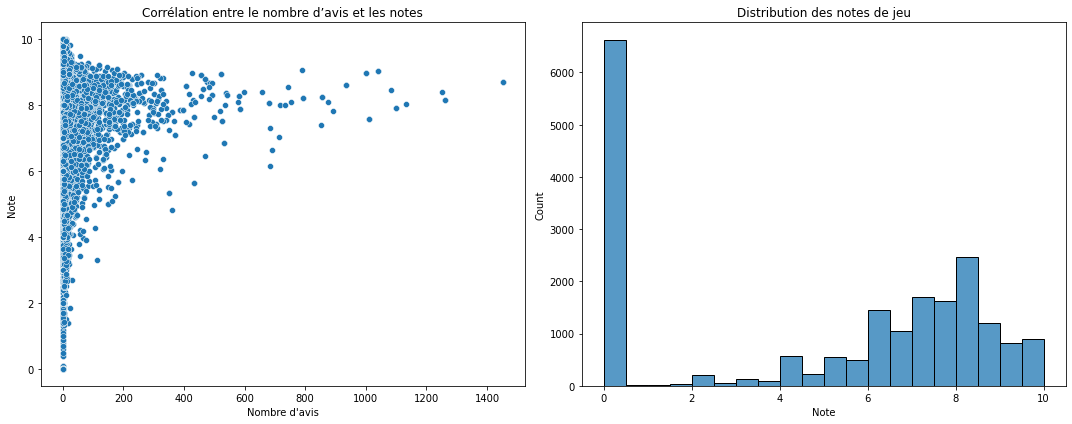

Coefficient de corrélation entre le nombre d’avis et les notes: 0.214


In [6]:

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=pdDetails, x='Nombre d\'avis', y='Note')
plt.title('Corrélation entre le nombre d’avis et les notes')
plt.xlabel("Nombre d'avis")
plt.ylabel('Note')

plt.subplot(1, 2, 2)
sns.histplot(data=pdDetails, x='Note', bins=20)
plt.title('Distribution des notes de jeu')
plt.xlabel('Note')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

correlation = pdDetails['Nombre d\'avis'].corr(pdDetails['Note'])
print(f"Coefficient de corrélation entre le nombre d’avis et les notes: {correlation:.3f}")
# Il y a une tendence ou des jeux avec plus de commentaires pour avoir des notes plus élevées
# Cependant, la corrélation est faible, ce qui suggère que le nombre d’avis n’est pas un indicateur fiable de la note d’un jeu

In [7]:
# Method 1: Using pdDetails to check games with 0 reviews
games_no_reviews_1 = len(pdDetails[pdDetails["Nombre d'avis"] == 0.0])

# Method 2: Using pdJeux to check games with no reviews
games_no_reviews_2 = len(pdJeux[pdJeux["avis"] == False])

print(f"Nombre de jeux avec 0 avis (utilisant pdDetails): {games_no_reviews_1}")
print(f"Nombre de jeux sans avis (en utilisant pdJeux): {games_no_reviews_2}")

# Calculate percentage
total_games = len(pdDetails)
percentage_no_reviews = (games_no_reviews_1 / total_games) * 100

print(f"\nPourcentage de jeux sans avis : {percentage_no_reviews:.2f}%")


#Probleme de consistence entre les 2 datas (ASK LE MONSIEUR)


Nombre de jeux avec 0 avis (utilisant pdDetails): 6616
Nombre de jeux sans avis (en utilisant pdJeux): 18

Pourcentage de jeux sans avis : 32.70%


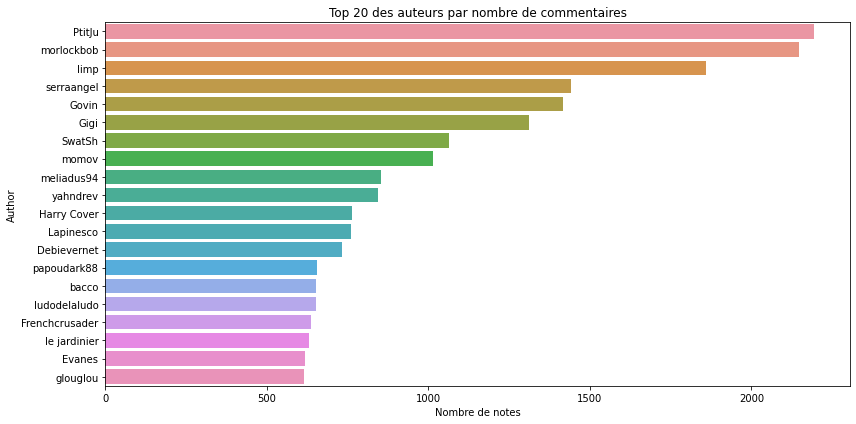

Nombre total d’auteurs uniques : 13623
Moyenne des avis par auteur : 18.10
Median des avis par auteur: 4.00

Top 5 most active reviewers:
PtitJu        2194
morlockbob    2146
limp          1858
serraangel    1442
Govin         1418
Name: author, dtype: int64


In [8]:
author_counts = pdAvis['author'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=author_counts.head(20).values, y=author_counts.head(20).index)
plt.title('Top 20 des auteurs par nombre de commentaires')
plt.xlabel('Nombre de notes')
plt.ylabel('Author')

plt.tight_layout()
plt.show()

print(f"Nombre total d’auteurs uniques : {len(author_counts)}")
print(f"Moyenne des avis par auteur : {author_counts.mean():.2f}")
print(f"Median des avis par auteur: {author_counts.median():.2f}")
print("\nTop 5 most active reviewers:")
print(author_counts.head())

 # DONT RUN UNLESS NECCESSARY (LONG RUN TIME)

[nltk_data] Downloading package stopwords to /Users/bido/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


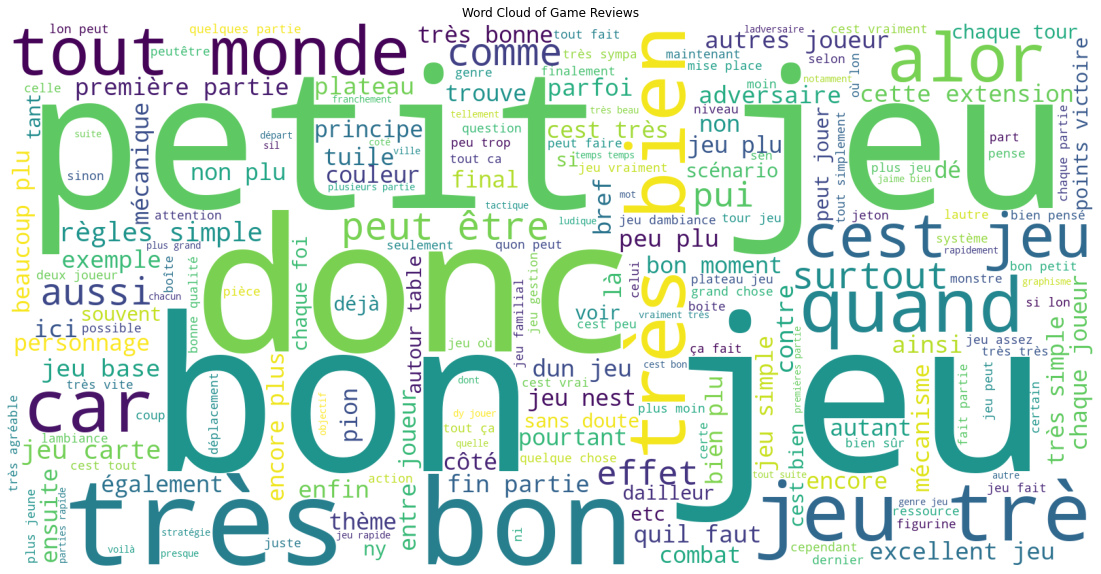


Most common words and their frequencies:
jeu: 398707
plus: 168988
a: 142221
cest: 139089
très: 124477
bien: 119982
tout: 102505
cartes: 87286
peu: 81352
si: 76575
joueurs: 69023
fait: 68122
partie: 66778
bon: 65102
peut: 59120
faire: 58765
ça: 56603
parties: 56155
jouer: 55604
jeux: 49581


In [106]:
# Download required NLTK data
nltk.download('stopwords')

# Get French stopwords
stop_words = set(stopwords.words('french'))

# Combine all comments
all_comments = ' '.join(pdAvis['comment'].dropna().astype(str))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

processed_text = preprocess_text(all_comments)

wordcloud = WordCloud(width=1600, height=800,
                     background_color='white',
                     min_font_size=10).generate(processed_text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Game Reviews')
plt.show()

words = processed_text.split()
word_freq = Counter(words).most_common(20)
print("\nMost common words and their frequencies:")
for word, freq in word_freq:
    print(f"{word}: {freq}")

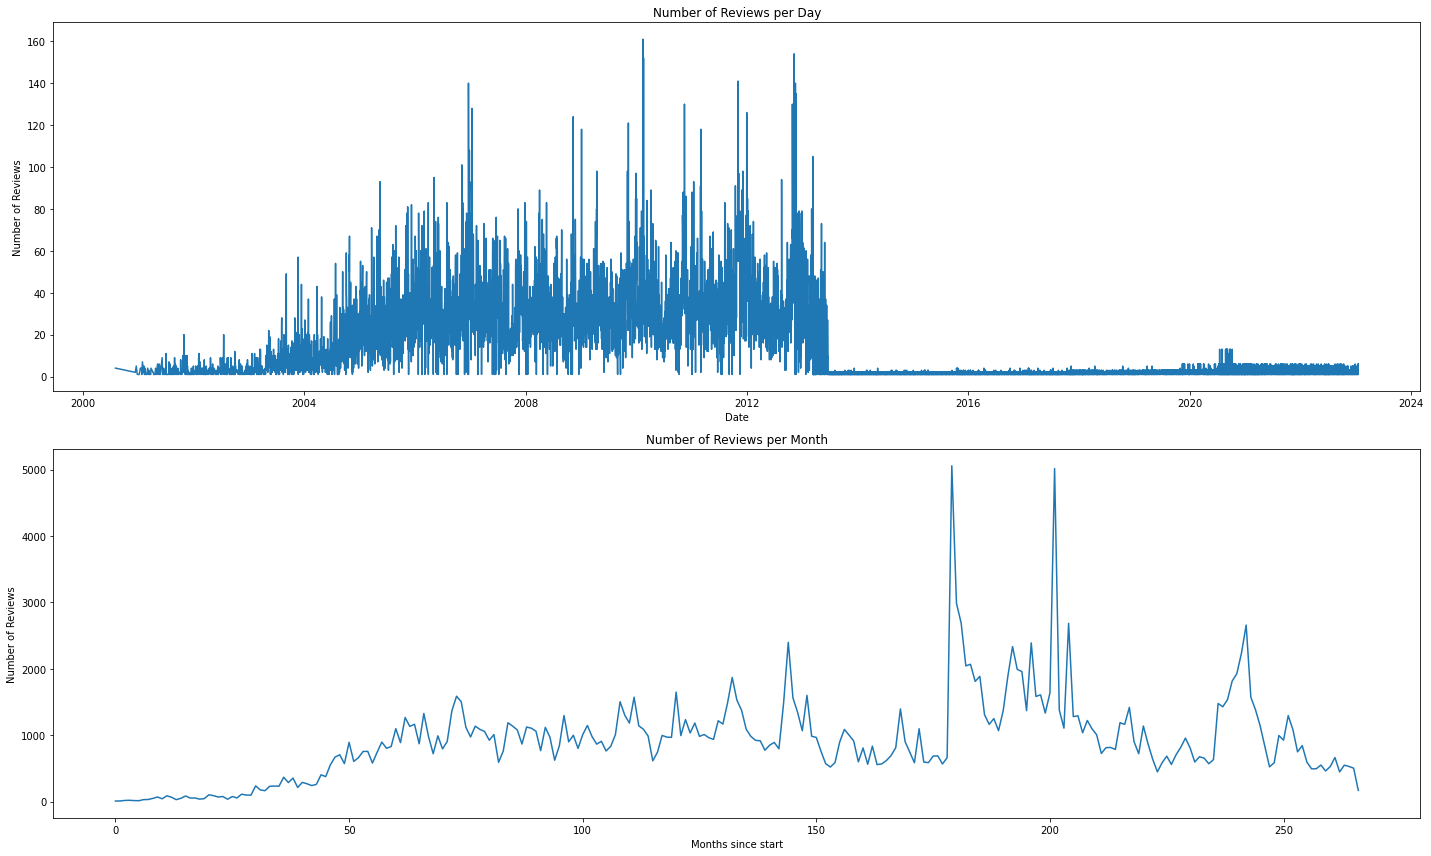

Total number of reviews: 246524
Average reviews per day: 3.16
Average reviews per month: 923.31
Most active day: 2010-02-14 with 161 reviews


In [9]:
# Convert date_published to datetime 
pdAvis['date_published'] = pd.to_datetime(pdAvis['date_published'])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Daily review counts
daily_reviews = pdAvis['date_published'].value_counts().sort_index()
ax1.plot(daily_reviews.index, daily_reviews.values)
ax1.set_title('Number of Reviews per Day')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Reviews')

# Monthly review counts
monthly_reviews = pdAvis.groupby(pdAvis['date_published'].dt.to_period('M')).size()
ax2.plot(range(len(monthly_reviews)), monthly_reviews.values)
ax2.set_title('Number of Reviews per Month')
ax2.set_xlabel('Months since start')
ax2.set_ylabel('Number of Reviews')


plt.tight_layout()
plt.show()

# Print statistics
print(f"Total number of reviews: {len(pdAvis)}")
print(f"Average reviews per day: {daily_reviews.mean():.2f}")
print(f"Average reviews per month: {monthly_reviews.mean():.2f}")
print(f"Most active day: {daily_reviews.index[daily_reviews.argmax()].date()} with {daily_reviews.max()} reviews")

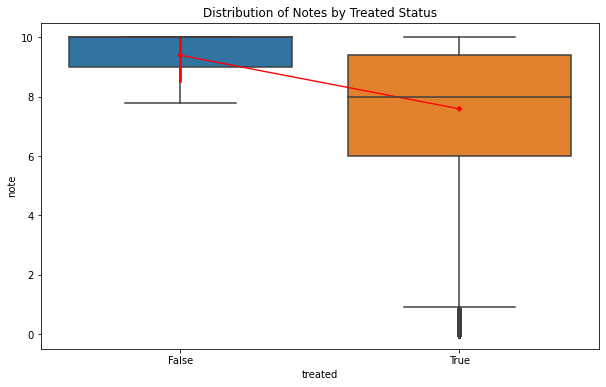


Average Notes by Treated Status:
             mean   count       std
treated                            
False    9.400000       7  1.026320
True     7.593019  246517  2.125892

t-statistic: -2.2488
p-value: 0.0245


In [10]:
# Calculate average note by treated group
avg_by_treated = pdAvis.groupby('treated')['note'].agg(['mean', 'count', 'std'])

# Perform t-test
treated = pdAvis[pdAvis['treated']]['note']
not_treated = pdAvis[~pdAvis['treated']]['note']
t_stat, p_value = stats.ttest_ind(treated, not_treated)

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='treated', y='note', data=pdAvis)
plt.title('Distribution of Notes by Treated Status')
plt.xlabel('Treated')
plt.ylabel('Note')

# Add means as points
sns.pointplot(x='treated', y='note', data=pdAvis, color='red', markers='D', scale=0.5)

plt.show()

# Print statistics
print("\nAverage Notes by Treated Status:")
print(avg_by_treated)
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# La valeur négative indique que le groupe traité a une note moyenne inférieure à celle du groupe non traité

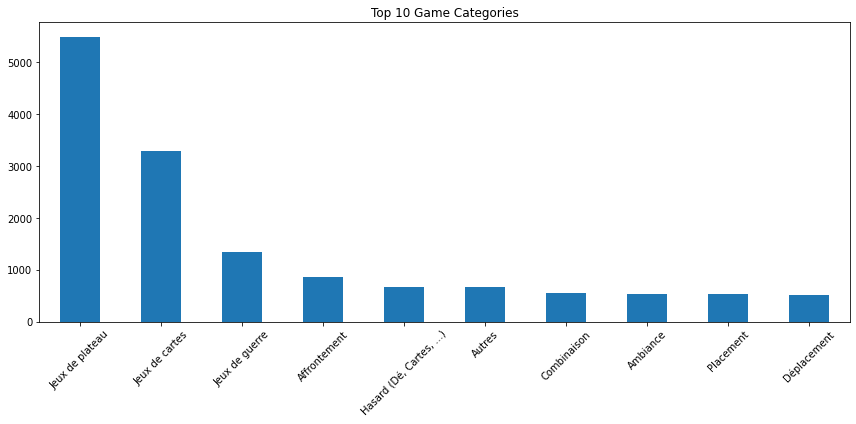

In [11]:
# Analyze game categories
def extract_categories(cat_str):
    if pd.isna(cat_str) or cat_str == "":
        return []
    return cat_str.split('|')

# Create category analysis
pdDetails['category_list'] = pdDetails['categories'].apply(extract_categories)
categories = [cat for cats in pdDetails['category_list'] for cat in cats]
cat_counts = pd.Series(categories).value_counts()

plt.figure(figsize=(12, 6))
cat_counts.head(10).plot(kind='bar')
plt.title('Top 10 Game Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
def extract_creators(casting):
    if pd.isna(casting):
        return []
    creators = re.findall(r'Par (.*?)(?:Illustré|Édité|$)', casting)
    return [c.strip() for c in creators]

pdDetails['creators'] = pdDetails['casting'].apply(extract_creators)
creators = [c for creators in pdDetails['creators'] for c in creators]
creator_counts = pd.Series(creators).value_counts()

print("Top 10 Game Creators:")
print(creator_counts.head(10))

Top 10 Game Creators:
Reiner Knizia        196
Steve Jackson         82
Michael Schacht       77
Klaus Teuber          68
Antoine Bauza         66
Martin Wallace        58
Friedemann Friese     56
Richard Borg          55
Uwe Rosenberg         52
Bruno Cathala         47
dtype: int64


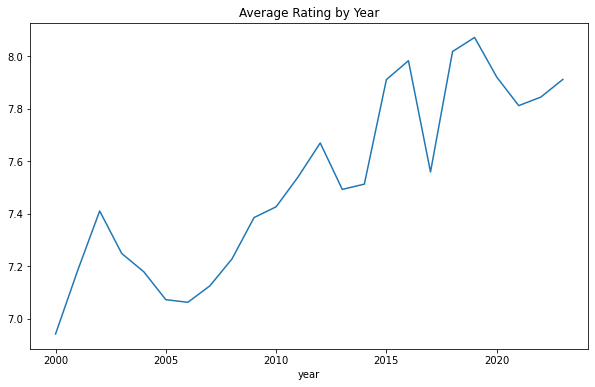

In [13]:
# Analyze rating trends over years
pdAvis['year'] = pdAvis['date_published'].dt.year
yearly_ratings = pdAvis.groupby('year')['note'].agg(['mean', 'count', 'std'])

plt.figure(figsize=(10, 6))
yearly_ratings['mean'].plot()
plt.title('Average Rating by Year')
plt.show()

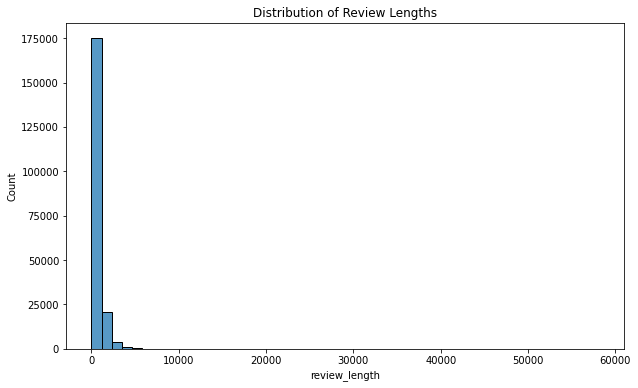

Average review length: 619 characters


In [14]:
pdAvis['review_length'] = pdAvis['comment'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(data=pdAvis, x='review_length',bins=50)
plt.title('Distribution of Review Lengths')
plt.show()

print(f"Average review length: {pdAvis['review_length'].mean():.0f} characters")

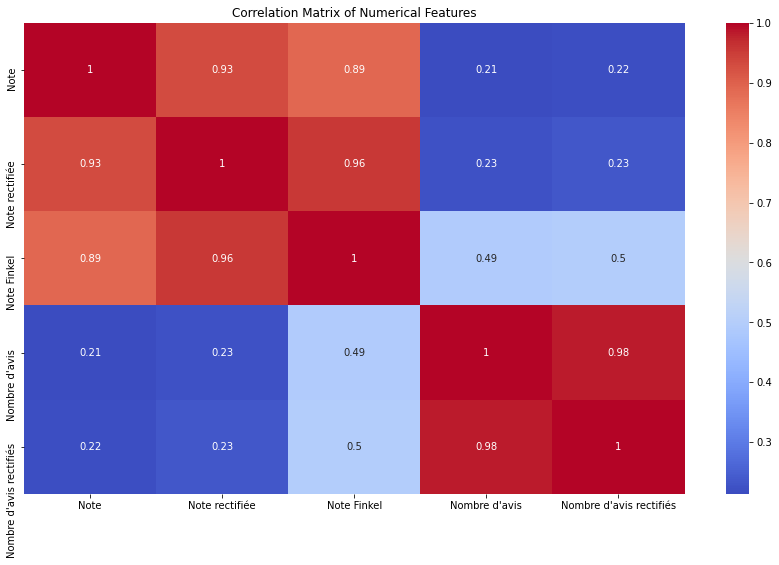

In [15]:
correlation_matrix = pdDetails.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

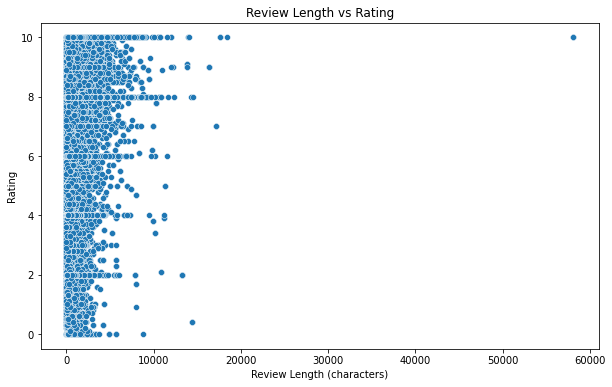

In [16]:
# Analyze if review length correlates with rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdAvis, x='review_length', y='note')
plt.title('Review Length vs Rating')
plt.xlabel('Review Length (characters)')
plt.ylabel('Rating')
plt.show()

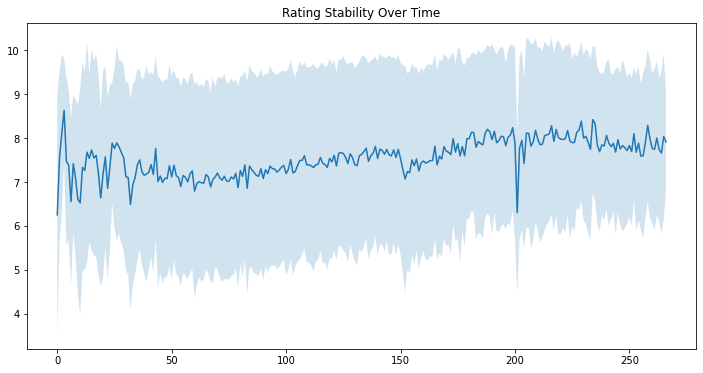

In [17]:
# Check if ratings are stable over time
pdAvis['month_year'] = pdAvis['date_published'].dt.to_period('M')
monthly_stats = pdAvis.groupby('month_year')['note'].agg(['mean', 'std'])

plt.figure(figsize=(12, 6))
plt.plot(range(len(monthly_stats)), monthly_stats['mean'])
plt.fill_between(range(len(monthly_stats)), 
                 monthly_stats['mean'] - monthly_stats['std'],
                 monthly_stats['mean'] + monthly_stats['std'],
                 alpha=0.2)
plt.title('Rating Stability Over Time')
plt.show()

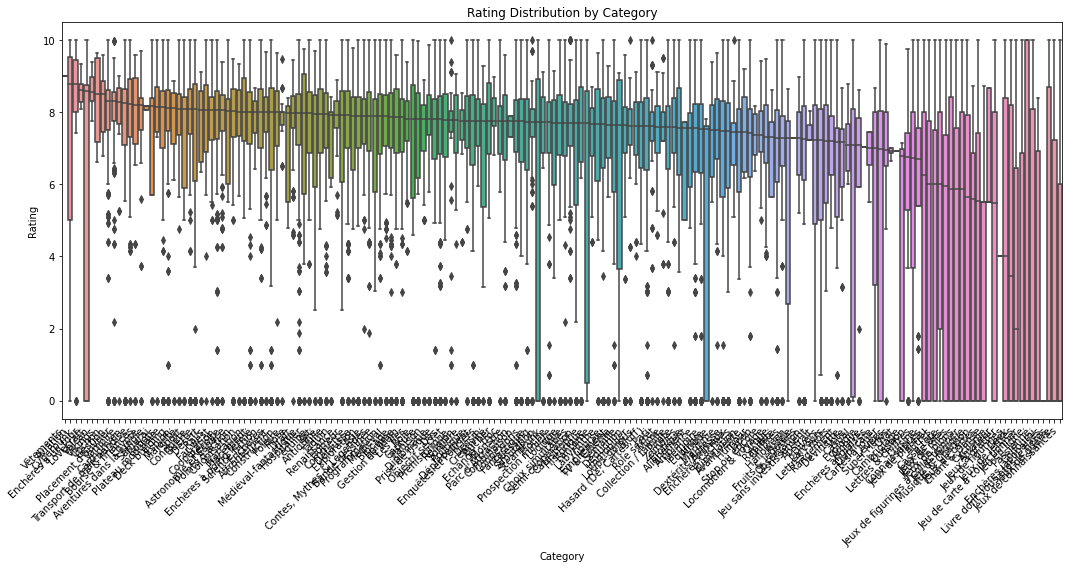


Category Statistics:
              count  mean  median   std
category                               
Abstrait        180  5.83    7.24  3.38
Affrontement    863  6.68    8.00  3.22
Afrique          30  6.93    7.50  2.17
Alignement       68  6.07    7.58  3.40
Amateur         218  4.24    5.50  4.01
...             ...   ...     ...   ...
Vote             23  6.32    7.10  2.60
Vêtements         2  9.00    9.00  0.00
Zombies         110  6.87    7.58  2.68
Équilibre        13  4.94    7.55  3.53
équipe          123  7.29    7.99  2.14

[184 rows x 4 columns]


In [18]:
# Expand categories into separate rows
category_ratings = []
for idx, row in pdDetails.iterrows():
    if isinstance(row['category_list'], list):
        for category in row['category_list']:
            category_ratings.append({
                'category': category,
                'rating': row['Note']
            })

# Create DataFrame and calculate category stats
cat_df = pd.DataFrame(category_ratings)
cat_stats = cat_df.groupby('category')['rating'].median().sort_values(ascending=False)

# Create box plot
plt.figure(figsize=(15, 8))
sns.boxplot(data=cat_df, x='category', y='rating', order=cat_stats.index)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.title('Rating Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.tight_layout()

# Display plot
plt.show()

# Print category statistics
print("\nCategory Statistics:")
print(cat_df.groupby('category')['rating'].agg(['count', 'mean', 'median', 'std']).round(2))

# Preprocessing

- We found 2 reviews with around 60000 words that arent interesting to keep (they are spam)

In [19]:
pdAvis[pdAvis["review_length"]>20000]

,_id,author,date_published,title_review,note,review_href,title,url,treated,comment,year,review_length,month_year
22193,63c67506993b727dc2a7a3a6,The Lonesome Meeple,2020-04-16 18:24:56,Histoire de Meeples #1 Sub Terra [Partie narra...,10.0,https://www.trictrac.net/avis/sub-terra-partie...,Sub Terra,https://www.trictrac.net/jeu-de-societe/sub-te...,True,Récit à retrouver sur mon blog Histoires de Me...,2020,58097.0,2020-04
79884,63c6776e993b727dc2a88501,The Lonesome Meeple,2020-04-16 18:24:56,Histoire de Meeples #1 Sub Terra [Partie narra...,10.0,https://www.trictrac.net/avis/sub-terra-partie...,Sub Terra,https://www.trictrac.net/jeu-de-societe/sub-te...,True,Récit à retrouver sur mon blog Histoires de Me...,2020,58097.0,2020-04


In [20]:
pdAvis=pdAvis[pdAvis["review_length"]<20000]

In [21]:
pdAvis[pdAvis["review_length"]>20000]

,_id,author,date_published,title_review,note,review_href,title,url,treated,comment,year,review_length,month_year


- We redid the statistcs about the review length to verify, all is good,the highest review is real

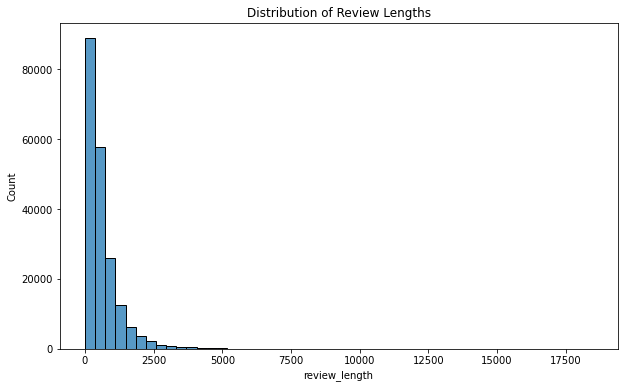

Average review length: 618 characters


In [22]:

plt.figure(figsize=(10, 6))
sns.histplot(data=pdAvis, x='review_length',bins=50)
plt.title('Distribution of Review Lengths')
plt.show()

print(f"Average review length: {pdAvis['review_length'].mean():.0f} characters")

In [23]:
allgames = sorted(pdJeux["title"].unique())
allusers = sorted(pdAvis['author'].unique())

print(f"Nombre des jeux {len(allgames)} et nombre de users {len(allusers)}")


Nombre des jeux 16366 et nombre de users 12035


# DONT RUN UNLESS NECESSARY

In [30]:
# Create empty DataFrame with users as index and games as columns
ratings_matrix = pd.DataFrame(
    index=allusers,
    columns=allgames,
    dtype=float
)

# Fill matrix with ratings
for _, row in pdAvis.iterrows():
    ratings_matrix.at[row['author'], row['title']] = row['note']


In [31]:
print(f"Matrix shape: {ratings_matrix.shape}")
print(f"\nMissing values: {ratings_matrix.isnull().sum().sum()}")
print(f"Fill rate: {(1 - ratings_matrix.isnull().sum().sum()/(len(allusers)*len(allgames)))*100:.2f}%")


# Check sparsity
non_null_counts = ratings_matrix.count()
print("\nTop 10 most rated games:")
print(non_null_counts.sort_values(ascending=False).head(10))

Matrix shape: (12035, 16366)

Missing values: 196814241
Fill rate: 0.08%

Top 10 most rated games:
Shogun                                 165
Samuraï                                150
Carcassonne - Die Jäger und Sammler    150
Ave Caesar                             150
La Città                               149
ARENA - Roma II                        149
Jeu de Cochons                         149
Mykerinos                              148
La Traversée du Désert                 148
Kiproko                                148
dtype: int64


In [32]:
ratings_matrix

,$ Fever,&#25112; &#22269;&#31574; &#19977;&#21313;&#20845;&#35745;,&cetera,'43,... Ma Non i Coperchi,...Und Tschüss,011,08/15,1 contre 100,1 contre 100 - Version électronique,...,Équilibre instable,Étoiles filantes,Été Indien,Îlots,Œufs volants !,€uromind,ごきぶりポーカー,シェフィ - Shephy,マイス - Mythe,ロンバルディアの王冠 (La Couronne de Lombardie)
#yuyu#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$lebat@$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
&lo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
*FitzChevalerie*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
*Nolehane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
|tigrou|,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
§Gama§,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
École du jeu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ær,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
ratings_matrix_cleaned = ratings_matrix.dropna(axis=1, how='all')
print(f"Removed {ratings_matrix.shape[1] - ratings_matrix_cleaned.shape[1]} games with no ratings")
copy= ratings_matrix_cleaned.copy()

Removed 5946 games with no ratings


In [34]:
review_counts = ratings_matrix_cleaned.count()
popular_games = review_counts[review_counts >= 135].index
# Create filter to remove any games with less then k reviews
ratings_matrix_cleaned = ratings_matrix_cleaned[popular_games]
ratings_matrix_cleaned = ratings_matrix_cleaned.dropna(axis=0, how='all') # remove all users who havent reviewed any games from the remaining games
ratings_matrix_cleaned

,ARENA - Roma II,Ave Caesar,Awale - Astérix,Babel,Ballon Cup,Bang!,BattleLore Seconde Édition,Belote,Blokus to go,Bohnanza,...,War of the ring : Anniversary Release,Yams / Yahtzee,Ys,Yspahan,Zombicide : Prison Outbreak,Zombies,Zombies!!!,Zou,Échecs,ごきぶりポーカー
*FitzChevalerie*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0livier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.100,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20cil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3dman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zorglub,NaN,NaN,NaN,NaN,NaN,NaN,10.0,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
zorl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
|tigrou|,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
§Gama§,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Computional problems

In [36]:
print(f"\nMissing values: {ratings_matrix_cleaned.isnull().sum().sum()}")
print(f"Fill rate: {(1 - ratings_matrix_cleaned.isnull().sum().sum()/(ratings_matrix_cleaned.shape[0]*ratings_matrix_cleaned.shape[1]))*100:.2f}%")



Missing values: 379290
Fill rate: 5.12%


In [37]:
from sklearn.decomposition import TruncatedSVD

def svd_impute(matrix, n_components=50):
    svd = TruncatedSVD(n_components=n_components)
    matrix_filled = matrix.fillna(matrix.mean())
    matrix_reduced = svd.fit_transform(matrix_filled)
    matrix_reconstructed = svd.inverse_transform(matrix_reduced)
    
    imputed_df = pd.DataFrame(
        matrix_reconstructed, 
        index=matrix.index, 
        columns=matrix.columns
    )
    
    # Keep original values, only fill NaNs
    mask = ~matrix.isna()
    imputed_df[mask] = matrix[mask]
    
    return imputed_df.clip(0, 10)  # Ensure values stay in valid range


def user_item_mean_impute(matrix):
    # Calculate user and item means
    user_means = matrix.mean(axis=1)
    item_means = matrix.mean()
    global_mean = matrix.mean().mean()
    
    # Fill NaNs with user-adjusted item means
    filled_matrix = matrix.copy()
    for user in matrix.index:
        user_bias = user_means[user] - global_mean
        for item in matrix.columns:
            if pd.isna(matrix.at[user, item]):
                predicted_rating = item_means[item] + user_bias
                filled_matrix.at[user, item] = np.clip(predicted_rating, 0, 10)
    
    return filled_matrix

In [38]:
filled_svd = svd_impute(ratings_matrix_cleaned)
filled_user_item = user_item_mean_impute(ratings_matrix_cleaned)

In [39]:
# Calculate statistics for each method
methods = {
    'SVD': filled_svd,
    'User-Item Mean': filled_user_item,
}

for name, matrix in methods.items():
    print(f"\n{name} Statistics:")
    print(f"Mean: {matrix.mean().mean():.2f}")
    print(f"Std: {matrix.std().std():.2f}")
    print(f"Distribution of values:")
    print(pd.qcut(matrix.values.flatten(), q=5).value_counts())
    
#Svd better distrubution, lower mean and lower std -> better stability of data and not overly optimistic,the quantilles are more uniform, the mean has more values at 10 


SVD Statistics:
Mean: 7.52
Std: 0.06
Distribution of values:
(-0.001, 6.961]    79954
(6.961, 7.402]     79952
(7.402, 7.861]     79953
(7.861, 8.236]     79953
(8.236, 10.0]      79953
dtype: int64

User-Item Mean Statistics:
Mean: 7.75
Std: 0.10
Distribution of values:
(-0.001, 6.373]    80042
(6.373, 7.59]      79866
(7.59, 8.378]      79994
(8.378, 9.478]     79912
(9.478, 10.0]      79951
dtype: int64


In [40]:
filled_svd

,ARENA - Roma II,Ave Caesar,Awale - Astérix,Babel,Ballon Cup,Bang!,BattleLore Seconde Édition,Belote,Blokus to go,Bohnanza,...,War of the ring : Anniversary Release,Yams / Yahtzee,Ys,Yspahan,Zombicide : Prison Outbreak,Zombies,Zombies!!!,Zou,Échecs,ごきぶりポーカー
*FitzChevalerie*,7.912287,7.198064,7.260361,7.401695,7.813613,7.014765,8.126653,7.248891,7.958776,7.834389,...,8.349924,6.027201,8.260091,8.459298,8.335524,6.849587,6.183601,6.926992,7.389445,7.030722
0livier,7.727167,7.333867,7.246699,7.344265,7.762732,6.969898,8.007128,7.119783,7.887426,7.789650,...,8.196882,5.997244,6.000000,8.375424,8.317564,6.897596,6.357053,6.884228,7.486215,6.974818
20.100,7.808061,7.442232,7.091946,6.000000,8.173949,6.587459,8.057279,7.326624,7.906535,7.966406,...,8.077278,6.475693,8.545791,8.720011,8.454949,7.095070,6.363330,6.649776,7.292865,7.242089
20cil,7.895334,7.356350,7.444383,7.358074,7.793552,7.092072,7.842773,7.383348,7.860165,7.786226,...,8.114321,6.109020,8.176878,8.400214,7.979404,6.982184,6.086432,6.762469,7.135838,6.915410
3dman,8.008420,7.291745,7.276186,7.370796,7.866277,6.803338,8.008303,7.290492,8.025317,7.870208,...,7.921933,6.092972,8.285510,8.406625,8.309674,4.000000,6.264954,6.890810,7.474174,6.888803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zorglub,7.915895,7.362653,7.440448,7.343511,7.799752,6.953143,10.000000,8.000000,7.981859,7.830261,...,7.982547,6.026742,8.288106,8.323343,8.279626,6.000000,6.305342,6.938221,7.438253,6.868480
zorl,7.828112,7.331496,7.336499,7.456038,7.968425,6.974532,7.939804,7.489430,8.013777,8.125398,...,8.148045,5.979831,8.487943,8.470859,8.211878,6.830597,6.114566,7.047324,7.482239,7.136930
|tigrou|,7.851982,7.253791,7.258980,8.000000,7.844027,6.913853,7.997054,7.222720,7.999191,7.864337,...,8.220959,5.996548,8.246247,8.470233,8.279885,6.861442,6.245306,6.993984,7.492936,7.035368
§Gama§,7.789732,7.227801,7.288653,7.383465,7.825045,7.134843,7.928844,7.294819,8.093046,7.919464,...,8.319338,5.945701,8.052211,8.453438,8.336795,6.871827,6.225030,6.923919,7.327890,6.912131



Evaluating KNN with euclidean distance and 4 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.145907  0.130010  0.860317   0.381973
1     2  0.160724  0.139656  0.850139   0.400833
2     3  0.135514  0.123047  0.869251   0.368122
3     4  0.145819  0.130292  0.861539   0.381858
4     5  0.142553  0.127201  0.864173   0.377561

Evaluating KNN with manhattan distance and 4 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.151596  0.130359  0.854870   0.389340
1     2  0.166240  0.139721  0.844996   0.407621
2     3  0.141204  0.123428  0.863761   0.375767
3     4  0.151009  0.130379  0.856611   0.388599
4     5  0.147416  0.126974  0.859540   0.383934

Evaluating KNN with cosine distance and 4 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.146974  0.130452  0.859296   0.383367
1     2  0.161337  0.139954  0.849568   0.401594
2

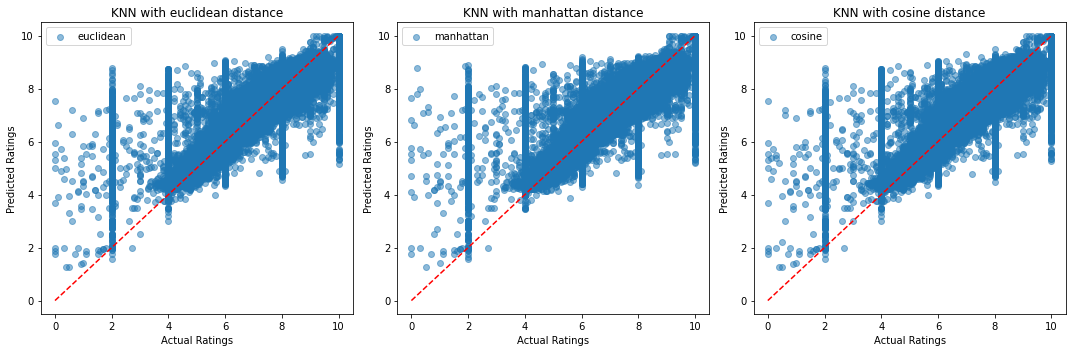


Evaluating KNN with euclidean distance and 7 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.149302  0.133283  0.857066   0.386388
1     2  0.165163  0.143572  0.846000   0.406316
2     3  0.139269  0.126965  0.865628   0.373184
3     4  0.150005  0.134272  0.857565   0.387304
4     5  0.146394  0.130468  0.860514   0.382609

Evaluating KNN with manhattan distance and 7 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.155393  0.134411  0.851236   0.394180
1     2  0.171495  0.144568  0.840096   0.413993
2     3  0.144952  0.127581  0.860145   0.380719
3     4  0.155096  0.134898  0.852730   0.393822
4     5  0.152815  0.131254  0.854396   0.390896

Evaluating KNN with cosine distance and 7 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.150284  0.133726  0.856126   0.387655
1     2  0.165592  0.143685  0.845600   0.406829
2

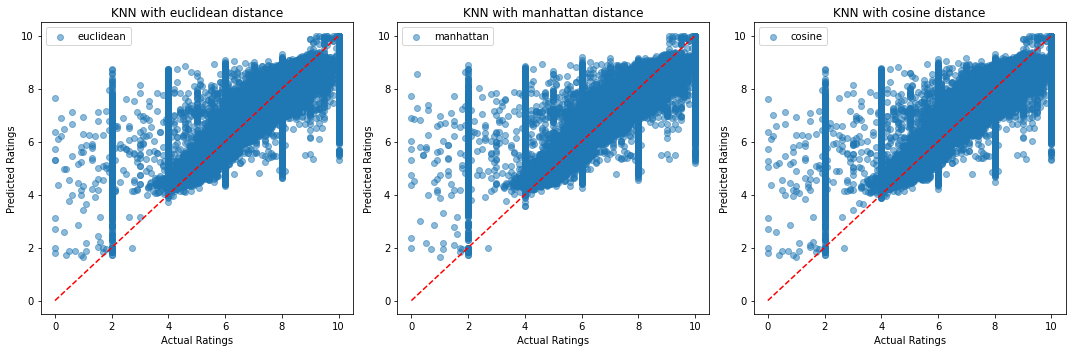


Evaluating KNN with euclidean distance and 10 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.153264  0.136550  0.853273   0.391478
1     2  0.169545  0.147091  0.841915   0.411648
2     3  0.142277  0.129981  0.862725   0.377193
3     4  0.153749  0.137605  0.854010   0.392108
4     5  0.150091  0.133385  0.856991   0.387406

Evaluating KNN with manhattan distance and 10 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.160004  0.137962  0.846821   0.399981
1     2  0.176161  0.148447  0.835746   0.419577
2     3  0.148219  0.131107  0.856993   0.384985
3     4  0.158886  0.138663  0.849132   0.398605
4     5  0.157203  0.134952  0.850215   0.396466

Evaluating KNN with cosine distance and 10 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.154029  0.136883  0.852541   0.392453
1     2  0.170233  0.147456  0.841273   0.41247

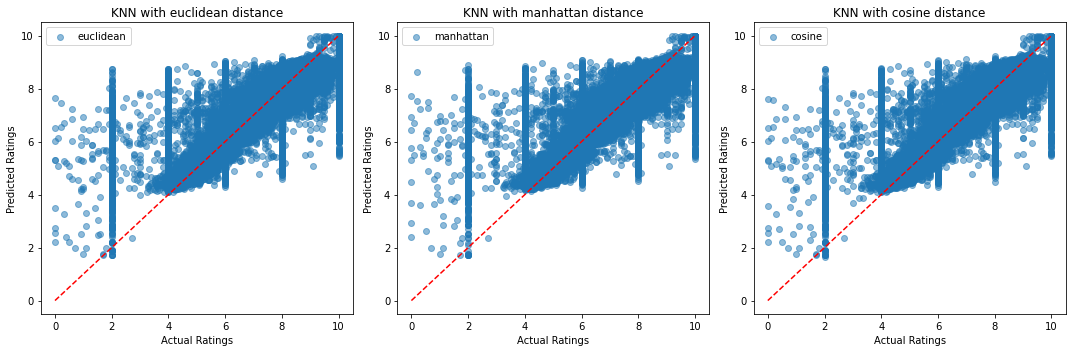


Evaluating KNN with euclidean distance and 13 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.157145  0.139462  0.849558   0.396401
1     2  0.173406  0.150020  0.838314   0.416310
2     3  0.145881  0.133008  0.859248   0.381941
3     4  0.157519  0.140802  0.850430   0.396887
4     5  0.153922  0.136189  0.853341   0.392316

Evaluating KNN with manhattan distance and 13 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.164006  0.141198  0.842990   0.404951
1     2  0.180643  0.151701  0.831567   0.424880
2     3  0.151824  0.134553  0.853515   0.389639
3     4  0.162602  0.141901  0.845603   0.403239
4     5  0.161284  0.138400  0.846326   0.401578

Evaluating KNN with cosine distance and 13 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.158008  0.139897  0.848732   0.397485
1     2  0.174283  0.150447  0.837497   0.41734

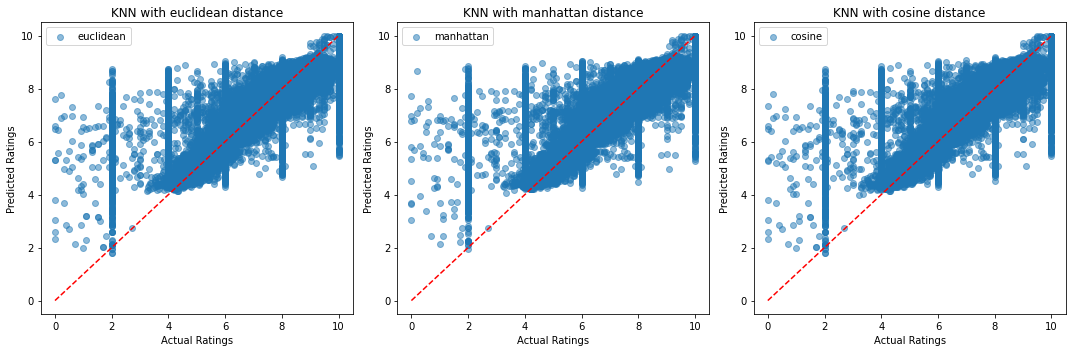


Evaluating KNN with euclidean distance and 16 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.160608  0.142277  0.846243   0.400745
1     2  0.177595  0.152985  0.834409   0.421307
2     3  0.149299  0.135973  0.855950   0.386390
3     4  0.160709  0.143624  0.847401   0.400885
4     5  0.157713  0.139230  0.849728   0.397118

Evaluating KNN with manhattan distance and 16 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.167397  0.144069  0.839743   0.409118
1     2  0.184400  0.154667  0.828064   0.429276
2     3  0.155102  0.137656  0.850352   0.393824
3     4  0.166522  0.145055  0.841881   0.408070
4     5  0.165056  0.141451  0.842732   0.406249

Evaluating KNN with cosine distance and 16 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.161769  0.142700  0.845131   0.402187
1     2  0.178092  0.153334  0.833945   0.42187

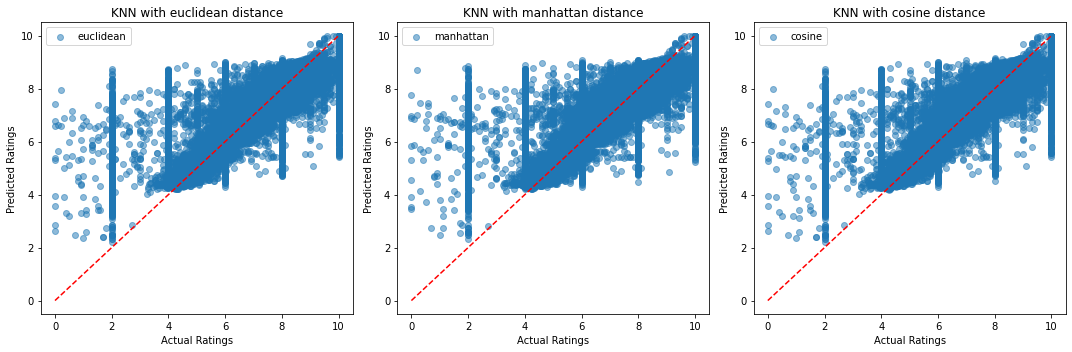

In [51]:


def evaluate_knn_with_kfold(X, metric, n_neighbors=10, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    all_predictions = []
    all_actual = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric=metric)
        
        fold_predictions = []
        fold_actual = []
        
        for idx in range(len(X_test)):
            user_ratings = X_test.iloc[idx]
            known = user_ratings.notna()

            if known.sum() > 0:
                X_train_filtered = X_train.loc[:, known]
                knn.fit(X_train_filtered, X_train_filtered.values)
                pred = knn.predict(X_test.loc[[X_test.index[idx]], known])

                fold_predictions.extend(pred.flatten())
                fold_actual.extend(user_ratings[known])
        
        mse = mean_squared_error(fold_actual, fold_predictions)
        r2 = r2_score(fold_actual, fold_predictions)
        mae = mean_absolute_error(fold_actual, fold_predictions)
        std_error = np.std(np.array(fold_actual) - np.array(fold_predictions))
        
        fold_results.append({
            'Fold': fold + 1,
            'MSE': mse, # The average squared difference between actual and predicted values.
            'MAE': mae, # The average absolute difference between actual and predicted values.
            'R2': r2, # A measure of how well the model explains variance in the data.
            'STD Error': std_error #The standard deviation of the residuals (prediction errors).
        })
        
        all_predictions.extend(fold_predictions)
        all_actual.extend(fold_actual)
    
    # Calculate average metrics across folds
    avg_metrics = {
        'MSE': np.mean([r['MSE'] for r in fold_results]),
        'MAE': np.mean([r['MAE'] for r in fold_results]),
        'R2': np.mean([r['R2'] for r in fold_results]),
        'STD Error': np.mean([r['STD Error'] for r in fold_results]),
        'Actual Ratings': all_actual,
        'Predicted Ratings': all_predictions
    }
    
    return avg_metrics, fold_results

# Test different metrics and store results
metrics = ['euclidean', 'manhattan', 'cosine']
for k in range(4,19,3):
    results = {}
    fold_results = {}

    for metric in metrics:
        print(f"\nEvaluating KNN with {metric} distance and {k} neighbors")
        results[metric], fold_results[metric] = evaluate_knn_with_kfold(filled_svd, metric, n_neighbors=k)
        
        # Print fold-wise results
        print(f"\nFold-wise results for {metric}:")
        fold_df = pd.DataFrame(fold_results[metric])
        print(fold_df)
     
    # Convert average results into a DataFrame
    results_df = pd.DataFrame.from_dict({m: {k: v for k, v in res.items() if k not in ['Actual Ratings', 'Predicted Ratings']} 
                                         for m, res in results.items()}, orient='index')
    
    print("\nAverage KNN Evaluation Results:")
    print(results_df)

    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics):
        actual_vals = results[metric]['Actual Ratings']
        predicted_vals = results[metric]['Predicted Ratings']

        plt.subplot(1, len(metrics), i+1)
        plt.scatter(actual_vals, predicted_vals, alpha=0.5, label=f"{metric}")
        plt.plot([min(actual_vals), max(actual_vals)], [min(actual_vals), max(actual_vals)], 'r--')
        plt.xlabel("Actual Ratings")
        plt.ylabel("Predicted Ratings")
        plt.title(f"KNN with {metric} distance")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Conclusion de la 1er semaine

## Les donnés

- We found many inconsistenties in the data (the nombre of non reviewed games between datasets
- we found 2 spam reviews
- No correlation between the number of reviews and rating
- Also no correlation between length of the review with the rating given
- There is a notable skew in the ratings distribution, with most ratings clustering around 7-8
- The data needs more cleaning

## Diffucltés

- The number of review are really low in comparison to the number of user*games without any cleaning we have 196814241 missing values with a fill rate of 0.08% which caused us big computional problems which meant that we spent a long time trying to fill the nun values.
- So we decided to take a very small portions of our data to be able to test knn. (games with more then 120 ratings and users who rated these games)
- With a fill rate so low we tried three different techniques to fill the values, first we tried to do a normal distrubition on each person while taking into consideration which category the game was in and if the person has other ratings in the same categories but this method appeared to be heavy on runtime and diffuclt to well implement as when tested on a small test dataset we found that due to the nature of how people rate (so most ratings are around 7) the disturbution was very centered around 7 and didnt capture well low ratings.
- So we decided to try a mean method where we took the mean of both the mean of the column(game) and the mean of lines (user), this showed  way better results but we also want to try with Singular value decomposition (svd) so we can see if we can use the patterns in the data to create better results.
- The statistics of svd fitted more with what we are trying to do so we choose it

## KNN

- with different folds, different number of neighbor, with different error metrics we discoverd multiple things:
    - First of the  manhatan distance had the worst results out of the 3, both euclidiene and cosine had very similar and better errors
    - while the error seems low, while looking at the graph and the std error we can see a big problem when it predicts wrong, it predicts them very wrong( predicting ratings that are less then 2 as high as 8 !!!!
    - Between the number of neighbor their wasnt any big difference in the results and also with different fold (although to be noted the 3rd fold was the best and the 2nd the worst).
    - The model seem to overly optimistic with its prediction.

Not necce